In [2]:
%load_ext tensorboard
#%matplotlib widget
import os
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Custom imports
from simulation.helpers.energyplus_util import tensorboard_logbase_dir, energyplus_logbase_dir
from postprocessing.tools.episode_visualization import run_gui
from postprocessing.tools.energyplus_analyzer import EnergyPlusAnalysis

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ModuleNotFoundError: No module named 'tensorflow'

### Load the data of a single episode

In [11]:
# Set the logging and output directory
log_dir = energyplus_logbase_dir()                  # This function determines the directory where the EnergyPlus simulation results are stored
run_dir = 'SB3_24_05_22_13h06_fruitpunch-dataset'   # Directory inside the data_dir where the specific simulation results are stored
data_dir = os.path.join(log_dir, run_dir)           # Directory with all the output data of a single simulation
output_dir = os.path.join(data_dir, 'output')       # Directory with the output data of a single simulation

# Determine the episode directories
episode_list = os.listdir(output_dir)
episode_list.sort()
episode_list = episode_list[:-3] + episode_list[-2:-1] # Remove the last and third to last episodes, as they are ALWAYS incomplete

# Load the data of the first episode
episode = episode_list[0]
episode_dir = os.path.join(output_dir, episode)     # Directory with the output data of the first episode
episode_data = pd.read_csv(os.path.join(episode_dir, 'eplusout.csv.gz'))

# Set constraint values
T_AL1_SP = 24
T_AL2_Constr = 30

### Renaming columns
The column names of the dataset are given automatically by energyplus, and are very long.
Here is a dictionary to make selecting columns more practical.

In [12]:
col_dict = {
    "CONDENSER WATER LOOP CT OUTLET NODE:System Node Mass Flow Rate [kg/s](TimeStep)": "m_Coondenser_Loop_1",
    "CONDENSER WATER LOOP CT OUTLET NODE:System Node Temperature [C](TimeStep)": "T_Condenser_Loop_1",
    "CONDENSER WATER LOOP CHILLER OUTLET NODE:System Node Temperature [C](TimeStep)": "T_Condenser_Loop_2",
    "CONDENSER WATER LOOP PUMP OUTLET NODE:System Node Temperature [C](TimeStep)": "T_Condenser_Loop_3",
    "COOLING TOWER SINGLE SPEED 1:Cooling Tower Fan Electricity Rate [W](TimeStep)": "P_Cooling_Tower",
    "COOLING TOWER SINGLE SPEED 1:Cooling Tower Fan Cycling Ratio [](TimeStep)": "Cooling_Tower_Fan_Cycle_Ratio",       # % of time this is turned on
    "CONDENSER WATER LOOP PUMP:Pump Electricity Rate [W](TimeStep)": "P_Condenser_Pump",
    "CHILLED WATER LOOP CHILLER OUTLET NODE:System Node Mass Flow Rate [kg/s](TimeStep)": "m_Chiller_Loop",             # ACTION VARIABLE
    "CHILLED WATER LOOP CHILLER OUTLET NODE:System Node Temperature [C](TimeStep)": "T_Chiller_Loop_1",
    "CHILLED WATER LOOP CLGCOIL OUTLET NODE:System Node Temperature [C](TimeStep)": "T_Chiller_Loop_2",
    "CHILLED WATER LOOP PUMP OUTLET NODE:System Node Temperature [C](TimeStep)": "T_Chiller_Loop_3",
    "CHILLER ELECTRIC EIR 1:Chiller Electricity Rate [W](TimeStep)": "P_Chiller",
    "CHILLER ELECTRIC EIR 1:Chiller Part Load Ratio [](TimeStep)": "Part_Load_Chiller",                                 # % of cooling capacity that is used
    "CHILLED WATER LOOP PUMP:Pump Electricity Rate [W](TimeStep)": "P_Chiller_Pump",
    "AIR LOOP CC OUTLET NODE:System Node Mass Flow Rate [kg/s](TimeStep)": "m_Air_Loop",                                # ACTION VARIABLE                
    "AIR LOOP CC OUTLET NODE:System Node Temperature [C](TimeStep)": "T_Air_Loop_3",
    "COMPUTERROOM ZN CRAC ELECTRIC STEAM HUMIDIFIER OUTLET AIR NODE:System Node Temperature [C](TimeStep)": "T_Air_Loop_4",
    "COMPUTERROOM ZN CRAC SUPPLY OUTLET NODE:System Node Temperature [C](TimeStep)": "T_Air_Loop_1",                    # The air setpoint temperature
    "COMPUTERROOM ZN CRAC DIFFUSER OUTLET AIR NODE:System Node Temperature [C](TimeStep)": "T_Air_Loop_1_5",            # Not there in the report
    "COMPUTERROOM ZN RETURN AIR NODE:System Node Temperature [C](TimeStep)": "T_Air_Loop_2",                            # The constraint temperature
    "COMPUTERROOM ZN CRAC ELECTRIC STEAM HUMIDIFIER:Humidifier Electricity Rate [W](TimeStep)": "P_Humidifier",
    "COMPUTERROOM ZN CRAC FAN:Fan Electricity Rate [W](TimeStep)": "P_Fan",
    "SMALLDATACENTERHIGHITE COMPUTERROOM IT EQUIPMENT 1:ITE CPU Electricity Rate [W](TimeStep)": "P_ITE_CPU",
    "SMALLDATACENTERHIGHITE COMPUTERROOM IT EQUIPMENT 1:ITE Fan Electricity Rate [W](TimeStep)": "P_ITE_Fan",
    "SMALLDATACENTERHIGHITE COMPUTERROOM IT EQUIPMENT 1:ITE UPS Electricity Rate [W](TimeStep)": "P_ITE_UPS",
    "SMALLDATACENTERHIGHITE COMPUTERROOM IT EQUIPMENT 1:ITE Total Heat Gain to Zone Rate [W](TimeStep)": "ITE_Heat_Gain_Rate",
    "Environment:Site Outdoor Air Wetbulb Temperature [C](TimeStep)": "T_outdoor",
    "CHILLED WATER LOOP SUPPLY OUTLET NODE:System Node Setpoint Temperature [C](TimeStep)": "T_Chiller_1_Setpoint",     # ACTION VARIABLE
}

episode_data.rename(columns=col_dict, inplace=True)
for column in episode_data.columns:
    print(column)

Date/Time
T_outdoor
P_ITE_CPU
P_ITE_Fan
P_ITE_UPS
SMALLDATACENTERHIGHITE COMPUTERROOM IT EQUIPMENT 1:ITE UPS Heat Gain to Zone Rate [W](TimeStep)
ITE_Heat_Gain_Rate
SMALLDATACENTERHIGHITE COMPUTERROOM IT EQUIPMENT 1:ITE Standard Density Air Volume Flow Rate [m3/s](TimeStep)
SMALLDATACENTERHIGHITE COMPUTERROOM IT EQUIPMENT 1:ITE Air Mass Flow Rate [kg/s](TimeStep)
SMALLDATACENTERHIGHITE COMPUTERROOM IT EQUIPMENT 1:ITE Air Inlet Dewpoint Temperature [C](TimeStep)
SMALLDATACENTERHIGHITE COMPUTERROOM IT EQUIPMENT 1:ITE Air Outlet Dry-Bulb Temperature [C](TimeStep)
COMPUTERROOM ZN:Zone ITE CPU Electricity Rate [W](TimeStep)
COMPUTERROOM ZN:Zone ITE Fan Electricity Rate [W](TimeStep)
COMPUTERROOM ZN:Zone ITE UPS Electricity Rate [W](TimeStep)
COMPUTERROOM ZN:Zone ITE Air Mass Flow Rate [kg/s](TimeStep)
CHW CLG COIL:Cooling Coil Total Cooling Rate [W](TimeStep)
P_Fan
P_Humidifier
Part_Load_Chiller
CHILLER ELECTRIC EIR 1:Chiller Cycling Ratio [](TimeStep)
P_Chiller
CHILLER ELECTRIC EIR 1:Chill

In [13]:
episode_data['COMPUTERROOM ZN RETURN AIR NODE:System Node Temperature [C](TimeStep)']

KeyError: 'COMPUTERROOM ZN RETURN AIR NODE:System Node Temperature [C](TimeStep)'

## Correcting datetime values
EnergyPlus uses warmup days for the simulation, these should be ignored. Also, date values are converted to DateTime

In [ ]:
def parse_datetime(dstr):
    # ' MM/DD  HH:MM:SS' or 'MM/DD  HH:MM:SS'
    # Dirty hack
    dstr = str(dstr)
    if dstr[0] != ' ':
        dstr = ' ' + dstr
    year = 2006 
    month = int(dstr[1:3])
    day = int(dstr[4:6])
    hour = int(dstr[8:10])
    minute = int(dstr[11:13])
    sec = 0
    msec = 0
    if hour == 24:
        hour = 0
        dt = datetime(year, month, day, hour, minute, sec, msec) + timedelta(days=1)
    else:
        dt = datetime(year, month, day, hour, minute, sec, msec)
    return dt

# Convert list of date/time string to list of datetime objects
def convert_datetime24(dates):
    # ' MM/DD  HH:MM:SS'
    dates_new = []
    for d in dates:
        dates_new.append(parse_datetime(d))
    return dates_new



# Remove the data before the first of January (these are warmup days)
mask = episode_data['Date/Time'].str.startswith(" 01/01")
episode_data = episode_data.loc[mask.idxmax():,:]

# Convert the Date/Time column to datetime objects
date_time = convert_datetime24(episode_data['Date/Time'])
episode_data['Date/Time'] = date_time

episode_data['T_Air_Loop_2']

/tmp/ipykernel_17149/348888652.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  episode_data['Date/Time'] = date_time


288      28.207998
289      46.448774
290      35.179191
291      36.898521
292      29.381603
           ...    
52843    29.121458
52844    29.785895
52845    29.380003
52846    29.041299
52847    28.669320
Name: T_Air_Loop_2, Length: 52560, dtype: float64

## Example plots

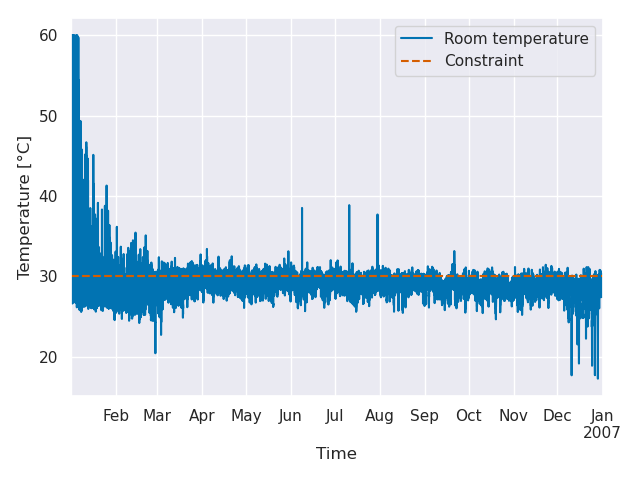

In [ ]:
# Room temperature vs. constraint
fig, ax = plt.subplots()
episode_data.plot(x='Date/Time', y='T_Air_Loop_2', ax=ax, label='Room temperature')
ax.hlines(T_AL2_Constr, episode_data['Date/Time'].iloc[0], episode_data['Date/Time'].iloc[-1], colors='r', linestyles='dashed', label='Constraint')
ax.set_ylabel('Temperature [°C]')
ax.set_xlabel('Time')
ax.legend()

plt.tight_layout()
plt.show()